In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
import matplotlib.image as mpimg

In [2]:
df_train = pd.read_csv('../input/planets-dataset/planet/planet/train_classes.csv')
df_train['image_name'] = '../input/planets-dataset/planet/planet/train-jpg'
df_train

,image_name,tags
0,../input/planets-dataset/planet/planet/train-jpg,haze primary
1,../input/planets-dataset/planet/planet/train-jpg,agriculture clear primary water
2,../input/planets-dataset/planet/planet/train-jpg,clear primary
3,../input/planets-dataset/planet/planet/train-jpg,clear primary
4,../input/planets-dataset/planet/planet/train-jpg,agriculture clear habitation primary road
...,...,...
40474,../input/planets-dataset/planet/planet/train-jpg,clear primary
40475,../input/planets-dataset/planet/planet/train-jpg,cloudy
40476,../input/planets-dataset/planet/planet/train-jpg,agriculture clear primary
40477,../input/planets-dataset/planet/planet/train-jpg,agriculture clear primary road


In [3]:
df_test = pd.read_csv('../input/planets-dataset/planet/planet/sample_submission.csv')
df_test['image_name'] = '../input/planets-dataset/planet/planet/test-jpg'
df_test['tags'] = df_train['tags'].apply(lambda x: x.split(' '))

In [4]:
df_train['tags2'] = df_train['tags'].apply(lambda x: x.split(' '))
labels_list = sum(list(df_train['tags2'].values), [])
labels = set(labels_list)

label_map = {l: i for i, l in enumerate(labels)}
inv_label_map = {i: l for l, i in label_map.items()}

In [5]:
label_map

{'road': 0,
 'conventional_mine': 1,
 'blow_down': 2,
 'blooming': 3,
 'water': 4,
 'cultivation': 5,
 'bare_ground': 6,
 'partly_cloudy': 7,
 'primary': 8,
 'habitation': 9,
 'cloudy': 10,
 'haze': 11,
 'selective_logging': 12,
 'slash_burn': 13,
 'clear': 14,
 'agriculture': 15,
 'artisinal_mine': 16}

Populating the interactive namespace from numpy and matplotlib


<AxesSubplot:>

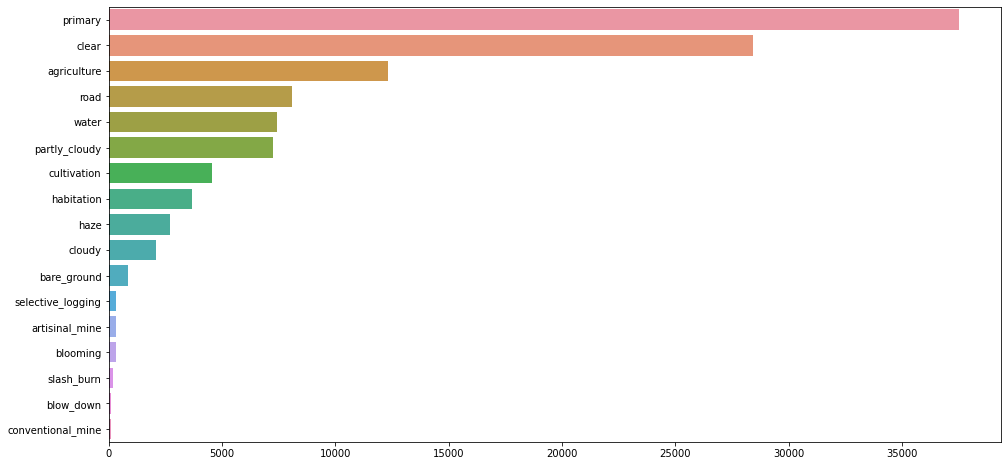

In [6]:
%pylab inline
import seaborn as sns

labels_s = pd.Series(labels_list).value_counts() # To sort them by count
fig, ax = plt.subplots(figsize=(16, 8))
sns.barplot(x=labels_s, y=labels_s.index, orient='h')

In [7]:
from sklearn.preprocessing import MultiLabelBinarizer
label_encoder = MultiLabelBinarizer()
Y = label_encoder.fit_transform(df_train['tags2']).astype(float)

In [8]:
def train(model, device, train_loader, optimizer, criterion, epoch):
    model.train() # 转为训练，drop起作用
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad() # 清空梯度
        output = model(data) # 正向传播
        loss = criterion(output, target) # 计算损失
        loss.backward() # 梯度计算
        optimizer.step() # 参数更新
        if batch_idx % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            
def test(model, device, test_loader, criterion):
    model.eval() 
    model_predict, model_target = [], []
    test_loss = 0
    with torch.no_grad():
        for data, target in tqdm_notebook(test_loader):
            data, target = data.to(device), target.to(device)
            output = model(data)
            
            model_predict.append(output.sigmoid().data.cpu().numpy())
            model_target.append(target.data.cpu().numpy())
            
            test_loss += criterion(output, target).item()  # sum up batch loss

    test_loss /= len(test_loader.dataset)
    f2_socre = []
    model_predict = np.vstack(model_predict)
    model_target = np.vstack(model_target)
    
    for idx in range(len(model_predict)):
        f2_socre.append(fbeta_score(model_predict[idx,:]>0.5, model_target[idx,:], beta=2))
    f2_socre = np.mean(f2_socre)
    
    print('\nTest set: Average loss: {:.4f} F2 Score: {:.4f}\n'.format(test_loss, f2_socre))
    
    return test_loss, f2_socre, model_predict